In [1]:
import os
import numpy as np
import random
import torch

from torch.utils.data import DataLoader, random_split

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMFineDataset, TransformDataset, TransformDatasetBalanced, find_overlapping_images, TensorFolderDataset

In [ ]:
# Definition if Data Augmentation is Applied and the folder to store the weights
data_augmentation = True
save_folder_base = "./data/fine"

In [ ]:
# Definition of the Data Folder and the initially set variables 
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten/nodule"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["A", "B", "E", "G"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

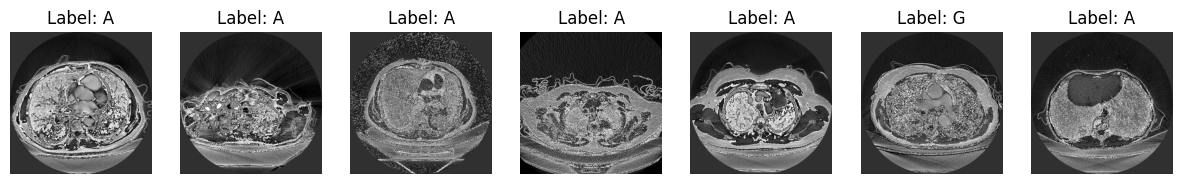

In [ ]:
# Visualization of different CT images from the Dataset with their correspongind labels
classes_dict = {value: index for index, value in enumerate(classes)}
dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes_dict)
# dataset = DICOMFineDataset(root_dir=BASE_DIR, classes=classes)
dataset.visualize_images(num_images=7)

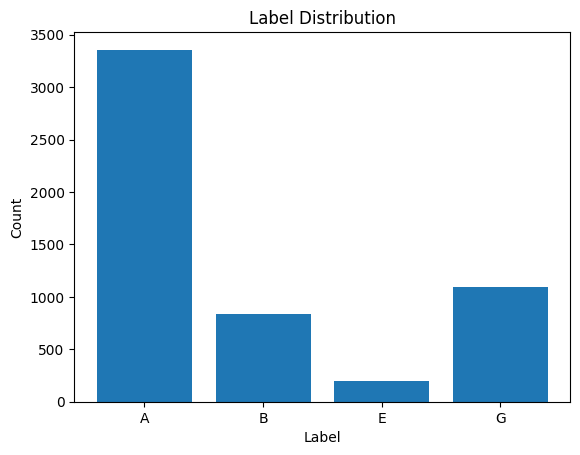

In [ ]:
# Visualization of the Label Distribution within the dataset
dataset.display_label_distribution()

In [ ]:
# Calculation of the Train, Validation and Test Size
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 3295 --- Validation size: 1098 --- Test size: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.109686..2.403777].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9442278..2.4494572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0692492..2.3193533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0169291..1.8609217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9503438..1.9828792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8612239..2.1839235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9610356.

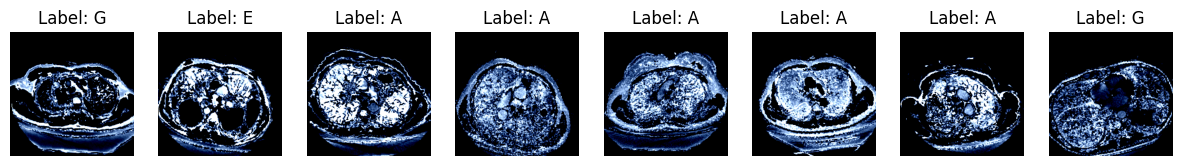

In [ ]:
# Visualization of CT images of the Dataset with the application of random data augmentation techniques
from utils import display_data_loader_batch
display_model = TransferLearningModel(classes, "resnet", data_augmentation=True, fine=False, scenario=1)
display_model.train_transforms, display_model.test_transforms = display_model.get_transforms()
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size])
train_dataset = TransformDataset(torch.utils.data.Subset(dataset, train_indices.indices), transform=display_model.train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
display_data_loader_batch(train_loader, classes)

In [8]:
train_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "train"))
val_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "val"))
test_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "test"))

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


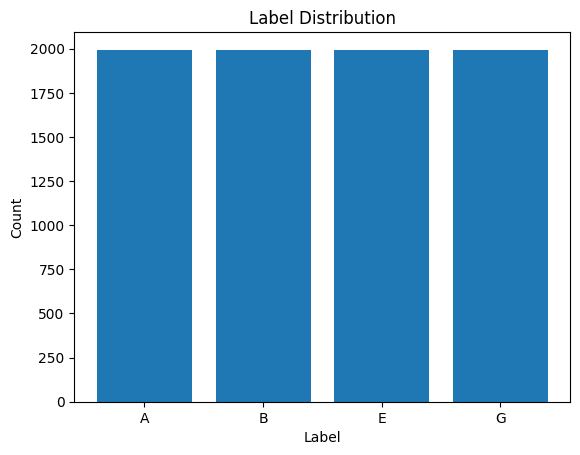

In [ ]:
# Balance the dataset by upsampling and visualize the label distribution again
train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict)
train_dataset.display_label_distribution()

In [ ]:
# Check for overlapping images in the different dataset splits (The overlapping images were manually checked and are truly not the same image)
val_dataset = TransformDataset(val_dataset_base)
test_dataset = TransformDataset(test_dataset_base)

find_overlapping_images(train_dataset, val_dataset)
find_overlapping_images(train_dataset, test_dataset)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Found 6 overlapping images
Train index: 3782, Test index: 3
Train index: 2948, Test index: 368
Train index: 1922, Test index: 545
Train index: 2034, Test index: 991
Train index: 629, Test index: 994
Train index: 1678, Test index: 1064
Found 4 overlapping images
Train index: 1889, Test index: 100
Train index: 2872, Test index: 161
Train index: 1978, Test index: 538
Train index: 1657, Test index: 1052


[100, 161, 538, 1052]

Processing model: resnet
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100
Epoch 1/50 ----- Loss: 1.0639, Accuracy: 54.86% ----- Validation Loss: 1.0139, Validation Accuracy: 53.27%
Epoch 2/50 ----- Loss: 0.8906, Accuracy: 63.49% ----- Validation Loss: 0.9959, Validation Accuracy: 59.04%
Epoch 3/50 ----- Loss: 0.8202, Accuracy: 66.46% ----- Validation Loss: 0.9104, Validation Accuracy: 59.71%
Epoch 4/50 ----- Loss: 0.7996, Accuracy: 67.92% ----- Validation Loss: 0.9524, Validation Accuracy: 58.27%
Epoch 5/50 ----- Loss: 0.7735, Accuracy: 69.11% ----- Validation Loss: 0.8864, Validation Accuracy: 62.21%
Epoch 6/50 ----- Loss: 0.7472, Accuracy: 69.50% ----- Validation Loss: 0.8650, Validation Accuracy: 60.99%
Epoch 7/50 ----- Loss: 0.7558, Accuracy: 69.13% ----- Validation Loss: 0.8719, Validation Accuracy: 61.88%
Epoch 8/50 ----- Loss: 0.7192, Accuracy: 71.20% ----- Validation Loss: 0.8503, Validation Accuracy: 63.38%
Epoch 9/50 ----- Loss: 0.7

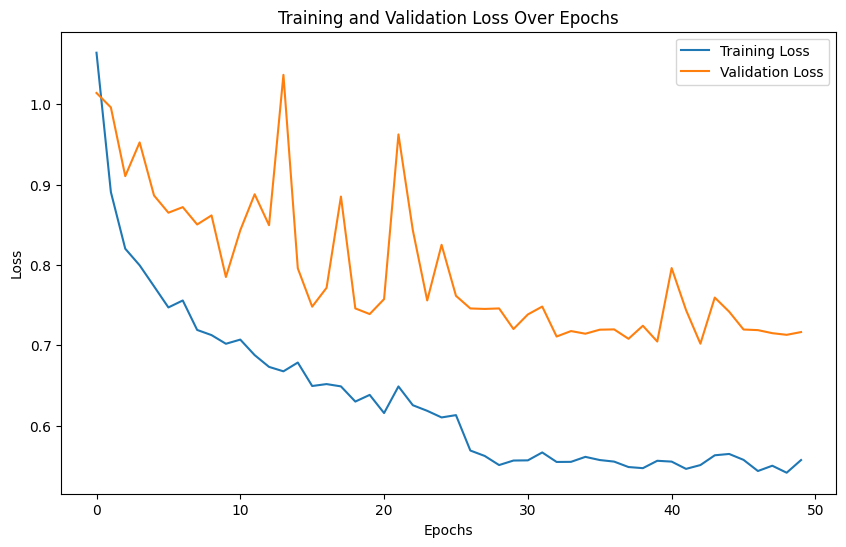

Processing model: densenet
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100
Epoch 1/50 ----- Loss: 1.0536, Accuracy: 56.57% ----- Validation Loss: 0.9870, Validation Accuracy: 58.38%
Epoch 2/50 ----- Loss: 0.8668, Accuracy: 65.94% ----- Validation Loss: 0.8827, Validation Accuracy: 64.19%
Epoch 3/50 ----- Loss: 0.7863, Accuracy: 69.42% ----- Validation Loss: 0.8071, Validation Accuracy: 69.12%
Epoch 4/50 ----- Loss: 0.7626, Accuracy: 69.43% ----- Validation Loss: 0.8777, Validation Accuracy: 59.89%
Epoch 5/50 ----- Loss: 0.7245, Accuracy: 71.28% ----- Validation Loss: 0.7308, Validation Accuracy: 71.07%
Epoch 6/50 ----- Loss: 0.6955, Accuracy: 72.25% ----- Validation Loss: 0.8129, Validation Accuracy: 64.41%
Epoch 7/50 ----- Loss: 0.6869, Accuracy: 72.57% ----- Validation Loss: 0.7951, Validation Accuracy: 64.96%
Epoch 8/50 ----- Loss: 0.6747, Accuracy: 73.57% ----- Validation Loss: 0.7132, Validation Accuracy: 72.54%
Epoch 9/50 ----- Loss: 0

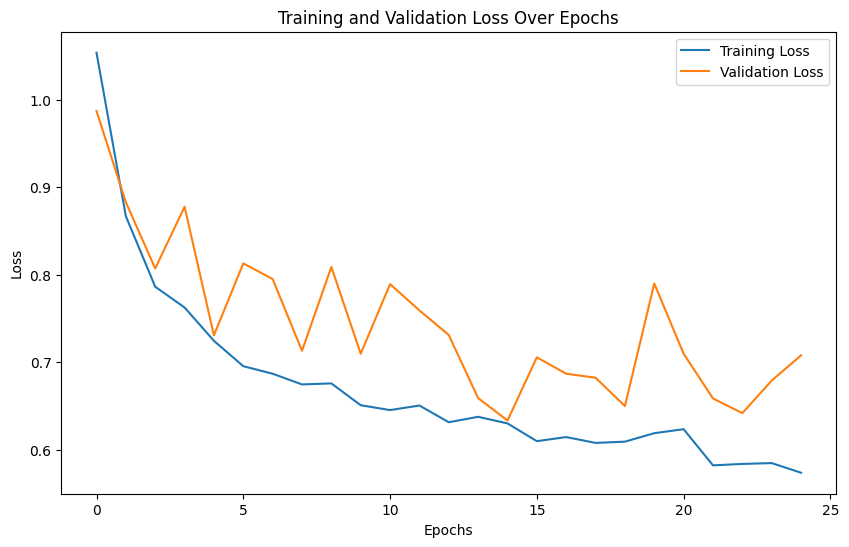

Processing model: efficientnet
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100
Epoch 1/50 ----- Loss: 0.6754, Accuracy: 72.71% ----- Validation Loss: 0.5566, Validation Accuracy: 77.98%
Epoch 2/50 ----- Loss: 0.2716, Accuracy: 89.53% ----- Validation Loss: 0.3879, Validation Accuracy: 87.83%
Epoch 3/50 ----- Loss: 0.1800, Accuracy: 93.36% ----- Validation Loss: 0.2135, Validation Accuracy: 94.30%
Epoch 4/50 ----- Loss: 0.1235, Accuracy: 95.61% ----- Validation Loss: 0.2579, Validation Accuracy: 93.57%
Epoch 5/50 ----- Loss: 0.1082, Accuracy: 95.94% ----- Validation Loss: 0.1312, Validation Accuracy: 95.88%
Epoch 6/50 ----- Loss: 0.0755, Accuracy: 97.44% ----- Validation Loss: 0.2485, Validation Accuracy: 92.98%
Epoch 7/50 ----- Loss: 0.0682, Accuracy: 97.63% ----- Validation Loss: 0.1050, Validation Accuracy: 96.51%
Epoch 8/50 ----- Loss: 0.0544, Accuracy: 98.16% ----- Validation Loss: 0.1412, Validation Accuracy: 96.14%
Epoch 9/50 ----- Los

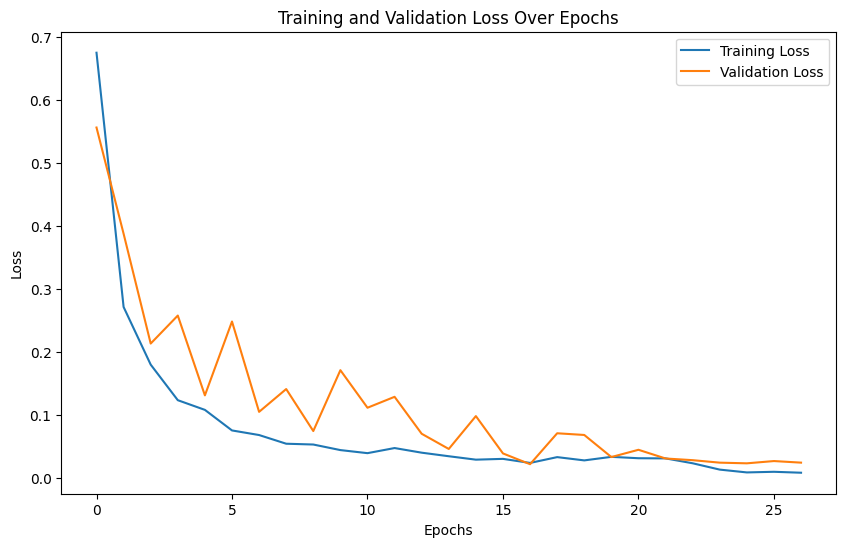

Processing model: efficientnet2
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100
Epoch 1/50 ----- Loss: 0.5288, Accuracy: 78.81% ----- Validation Loss: 0.5993, Validation Accuracy: 77.39%
Epoch 2/50 ----- Loss: 0.1473, Accuracy: 94.92% ----- Validation Loss: 0.1878, Validation Accuracy: 92.02%
Epoch 3/50 ----- Loss: 0.0863, Accuracy: 97.02% ----- Validation Loss: 0.0955, Validation Accuracy: 96.10%
Epoch 4/50 ----- Loss: 0.0488, Accuracy: 98.35% ----- Validation Loss: 0.1559, Validation Accuracy: 95.40%
Epoch 5/50 ----- Loss: 0.0513, Accuracy: 98.33% ----- Validation Loss: 0.1040, Validation Accuracy: 97.10%
Epoch 6/50 ----- Loss: 0.0383, Accuracy: 98.76% ----- Validation Loss: 0.0446, Validation Accuracy: 98.53%
Epoch 7/50 ----- Loss: 0.0322, Accuracy: 99.13% ----- Validation Loss: 0.0733, Validation Accuracy: 97.65%
Epoch 8/50 ----- Loss: 0.0335, Accuracy: 98.93% ----- Validation Loss: 0.0321, Validation Accuracy: 98.38%
Epoch 9/50 ----- Lo

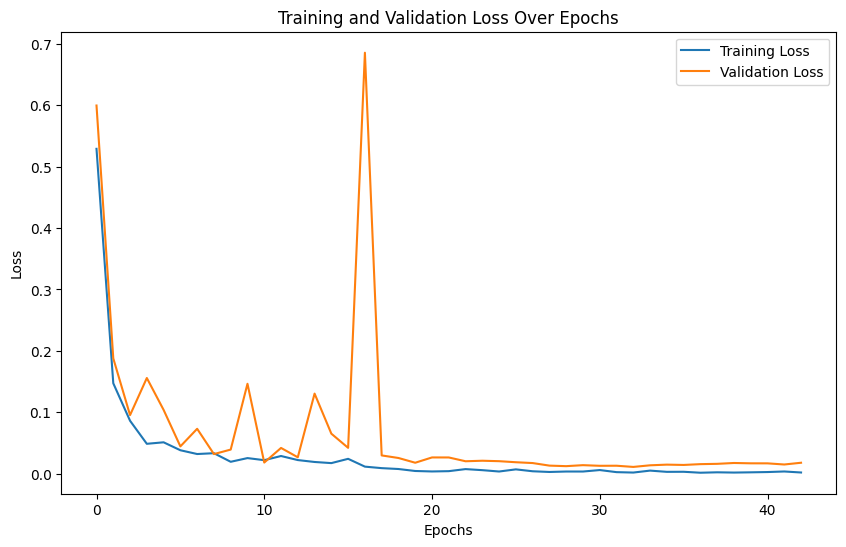

Processing model: efficientnet3
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100
Epoch 1/50 ----- Loss: 0.5881, Accuracy: 76.28% ----- Validation Loss: 0.2575, Validation Accuracy: 91.25%
Epoch 2/50 ----- Loss: 0.2536, Accuracy: 91.00% ----- Validation Loss: 0.1733, Validation Accuracy: 93.82%
Epoch 3/50 ----- Loss: 0.1567, Accuracy: 94.20% ----- Validation Loss: 0.1585, Validation Accuracy: 94.85%
Epoch 4/50 ----- Loss: 0.1235, Accuracy: 95.69% ----- Validation Loss: 0.0879, Validation Accuracy: 97.06%
Epoch 5/50 ----- Loss: 0.1076, Accuracy: 96.20% ----- Validation Loss: 0.0988, Validation Accuracy: 95.59%
Epoch 6/50 ----- Loss: 0.0963, Accuracy: 96.55% ----- Validation Loss: 0.0550, Validation Accuracy: 98.24%
Epoch 7/50 ----- Loss: 0.0870, Accuracy: 96.85% ----- Validation Loss: 0.0976, Validation Accuracy: 97.61%
Epoch 8/50 ----- Loss: 0.0701, Accuracy: 97.63% ----- Validation Loss: 0.0944, Validation Accuracy: 96.65%
Epoch 9/50 ----- Lo

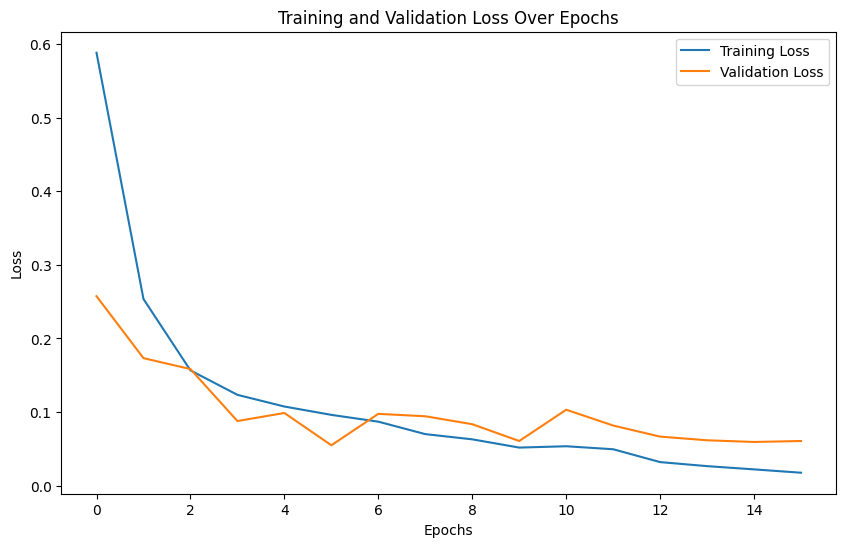

Processing model: vit
Train size upsampled: 7976 --- Validation size upsampled: 2720 --- Test size upsampled: 1100


c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50 ----- Loss: 0.8678, Accuracy: 66.49% ----- Validation Loss: 0.8318, Validation Accuracy: 67.87%
Epoch 2/50 ----- Loss: 0.6361, Accuracy: 76.58% ----- Validation Loss: 0.8401, Validation Accuracy: 62.94%
Epoch 3/50 ----- Loss: 0.5644, Accuracy: 78.77% ----- Validation Loss: 0.7760, Validation Accuracy: 67.76%
Epoch 4/50 ----- Loss: 0.5170, Accuracy: 81.34% ----- Validation Loss: 0.7417, Validation Accuracy: 68.31%
Epoch 5/50 ----- Loss: 0.4817, Accuracy: 82.32% ----- Validation Loss: 0.7588, Validation Accuracy: 66.32%
Epoch 6/50 ----- Loss: 0.4596, Accuracy: 83.70% ----- Validation Loss: 0.7148, Validation Accuracy: 70.18%
Epoch 7/50 ----- Loss: 0.4322, Accuracy: 84.08% ----- Validation Loss: 0.6699, Validation Accuracy: 72.72%
Epoch 8/50 ----- Loss: 0.4261, Accuracy: 84.80% ----- Validation Loss: 0.7023, Validation Accuracy: 70.11%
Epoch 9/50 ----- Loss: 0.4138, Accuracy: 84.80% ----- Validation Loss: 0.7585, Validation Accuracy: 65.59%
Epoch 10/50 ----- Loss: 0.3965, Accur

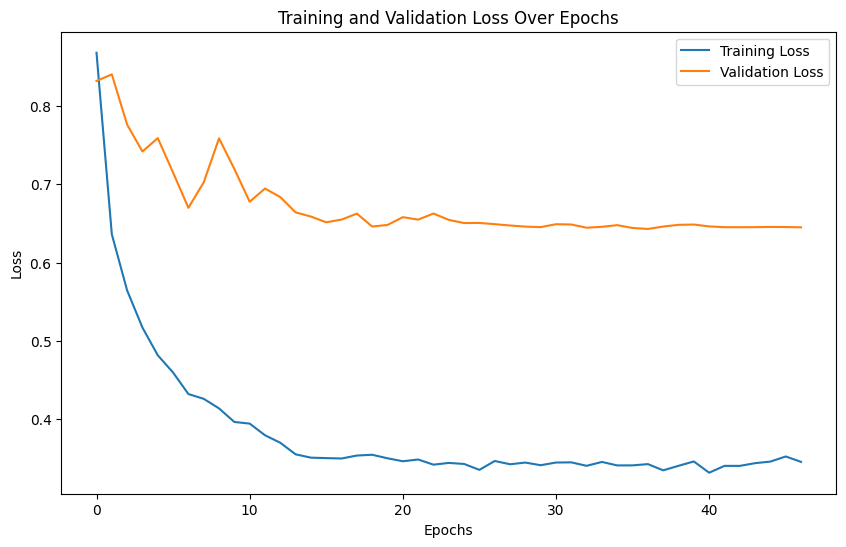

The best model is efficientnet2 with a validation loss of 0.0180


In [ ]:
# Iterate through the different 2D transfer learning classifiers and execute the training process for each and safe
# the best performing model based on the validation loss during the training stage
model_names = ["resnet", "densenet", "efficientnet", "efficientnet2", "efficientnet3", "vit"]
best_val_loss = float('inf')
best_model = None

for model_name in model_names:
    print(f"Processing model: {model_name}")
    current_model = TransferLearningModel(classes, model_name, data_augmentation=data_augmentation, fine=True)

    # Ensure transforms are correctly applied based on model requirements
    current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()

    # Apply specific transforms to each subset
    train_dataset = TransformDatasetBalanced(train_dataset_base, classes=classes_dict, transform=current_model.train_transforms)
    val_dataset = TransformDatasetBalanced(val_dataset_base, classes=classes_dict, transform=current_model.test_transforms)
    test_dataset = TransformDataset(test_dataset_base, transform=current_model.test_transforms)

    print(f"Train size upsampled: {len(train_dataset)} --- Validation size upsampled: {len(val_dataset)} --- Test size upsampled: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)

    # Train the current model
    current_model.train(train_loader, val_loader, early_stopping, epochs=50)

    # Track the best model based on validation loss
    final_val_loss = current_model.val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = current_model

print(f"The best model is {best_model.model_name} with a validation loss of {best_val_loss:.4f}")

Best model: efficientnet2


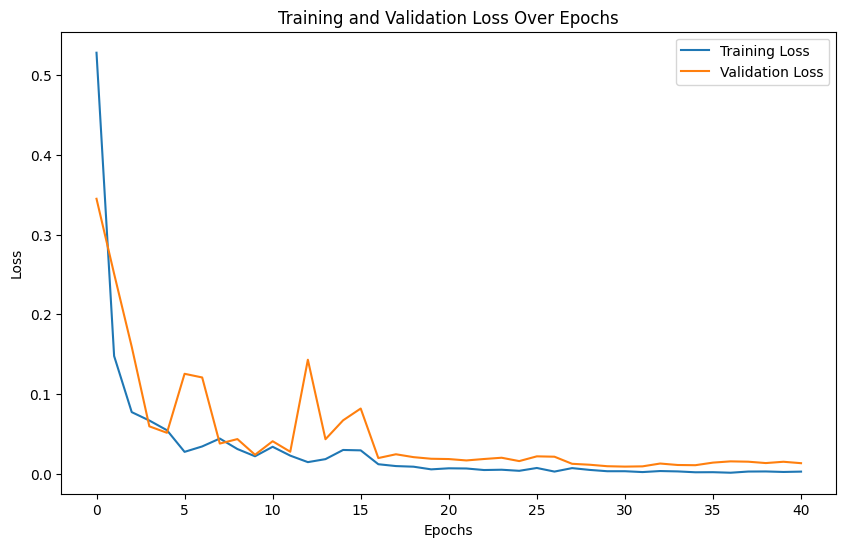

In [ ]:
# Visualization of the training and validation loss for the best performing model
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

Best model: efficientnet2
9.650296035814042e-05
Evaluation Accuracy on unseen data: 100.0


<Figure size 1000x800 with 0 Axes>

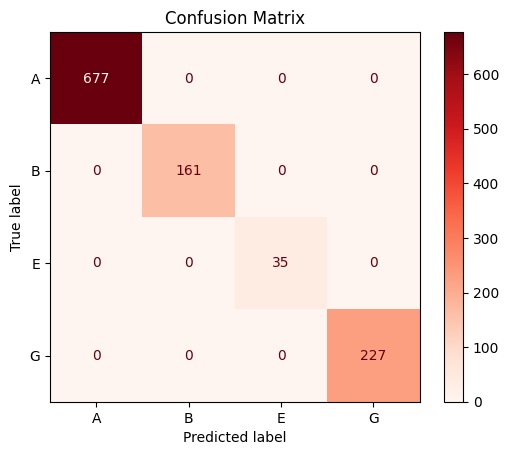

In [ ]:
# Load the best model from the weights and execute the evaluation process
print(f"Best model: {best_model.model_name}")
checkpoint = torch.load(f"weights/fine/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)

0.6428770426441641


c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\Final Models\utils.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Evaluation Accuracy on unseen data: 74.54545454545455


<Figure size 1000x800 with 0 Axes>

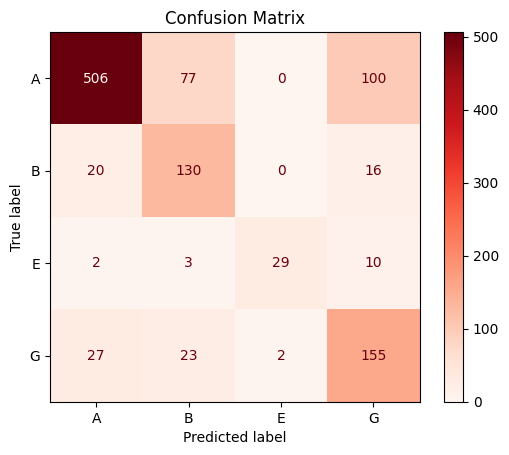

In [ ]:
# Evaluation Setup for a specific model
data_augmentation = True
test_model_name = "vit"

test_model = TransferLearningModel(classes, test_model_name, data_augmentation=data_augmentation, fine=True)
test_model.train_transforms, test_model.test_transforms = test_model.get_transforms()

test_dataset_base = TensorFolderDataset(os.path.join(save_folder_base, "test"))
test_dataset = TransformDataset(test_dataset_base, transform=current_model.test_transforms)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

checkpoint = torch.load(f"weights/fine/augmented_{test_model.model_name}.pt", weights_only=False)
test_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
test_model.evaluate(test_loader)